### To get started with this notebook: 

#### Select `Run All Cells` from the `Run` drop-down in the top left menu bar.

In [1]:
%pip install ../../epx_client

Processing /home/epx/epx_client
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pydot-2.0.0-py3-none-any.whl (22 kB)
  Using cached types_networkx-3.2.1.20240531-py3-none-any.whl (122 kB)
  Created wheel for epx: filename=epx-0.1.2-py3-none-any.whl size=58165 sha256=419590f8d5cf339ea2c1f1b3b63405b3294f809b750e5c50c859eaa594f4474d
  Stored in directory: /tmp/pip-ephem-wheel-cache-ehc6hi4y/wheels/33/27/61/37e8e96d13e58de69cf7d9ac63a17cac01e06d2e82473ec11a
Successfully built epx
  Attempting uninstall: epx
    Found existing installation: epx 0.1.1
    Uninstalling epx-0.1.1:
      Successfully uninstalled epx-0.1.1
Note: you may need to restart the kernel to use updated packages.


In [58]:
from epx import Job, ModelConfig, SynthPop

import animate as animate
from IPython.display import HTML
import networkx as nx
from networkx.classes.reportviews import NodeView
from tempfile import NamedTemporaryFile
import shutil
from statistics import mean, StatisticsError
import json

# Classic Schelling Model on a Grid

Thomas Schelling's classic agent-based model of residential segregation demonstrates that, under certain circumstances, individual preferences for having a relatively modest fraction of your neighbors share a common characteristic (in his model, race; in our implementation, red or blue color) are sufficient to generate communities that exhibit a surprising degree of segregation along the lines of that characterstic.

One of those circumstances in that original model is that the agents live on a grid of households, where each household has 8 neighboring households, some fraction of which are unoccupied. Then, agents evaluate whether they are happy with their current household location by determining whether the fraction of their neighbors that share the same value for the key characteristic exceeds a given threshold. If an agent determines that they are unhappy with their current household location, then they will move to a random unoccupied house.

However, we can think of a grid as being just one special case of a network topology and ask: How (if at all) do the dynamics of the Schelling model change if we change the network topology?

This is more than just an academic question --- there are many spaces, e.g., online spaces, where agents might choose to seek out "neighbors" who are "similar" to them in some way, but where their choice of neighbors is less limited by the geography of the physical environment. And, in these settings, as in the (stylized) physical setting of the original models, the dynamics of Schelling-type models can tell us something about how communities might emerge in those environments. For example, if we consider the network as representing a conduit for information, in addition to representing a "neighbor" relationship, e.g., on a social media platform, then the tendency of agents to "segregate" (or not "segregate") in that environment may help uncover insights about phenomena like political polarization or extremification (think "echo chambers" or "filter bubbles").

One advantage of the structured environment of the grid, however, is that it is easy to see whether segregation emerges in a given simulation. It is very visually apparent! To explore the dynamics of the Schelling model on more general networks, which in general do not have a convenient standard visual representation like a grid, we will need to use new tools. For each simulation:
1. We compute the average fraction of red neighbors across all agents of each color. For blue agents, this is the fraction of their neighbors who are different from them. For red agents, it is the fraction of their neighbors who are similar to them.
2. We create an animation of the network on each day of the simulation, where an agent's position in the horizontal direction indicates their fraction of red neighbors. Thus, blue (resp. red) agents will move to the left (right) as their fraction of similar neighbors increases. An agent's position in the vertical direction is arbitrary. (I recommend clicking through these animations frame-by-frame using the single-arrow-followed-by-vertical-bar buttons.)

First, let's look at these outputs for the standard Schelling model on a grid:

In [89]:
# Define model configuration and associated job, plus a job-running helper function
# Note that we need to pass a placeholder location, as "none" is not yet supported.

schelling_grid_config = ModelConfig(synth_pop=SynthPop("US_2010.v5", ["Loving_County_TX"]),
    start_date = "2023-01-01",
    end_date = "2023-01-10")


# Configure FRED job

results_dir = "/home/epx/cl-results"

schelling_grid_job = Job(
    "model/schelling_grid.fred",
    config=[schelling_grid_config],
    key="ng_schelling_grid_job",
    results_dir=results_dir,
    size="hot",
    # Select FRED version compatible with selected model
    fred_version="11.0.1"
)

import time
def exec_job_with_timer(job: Job):
    
    job.execute()
    
    # the following loop idles while we wait for the simulation job to finish
    start = time.time()
    timeout   = 3000 # timeout in seconds
    idle_time = 3   # time to wait (in seconds) before checking status again
    while str(job.status) not in ['DONE', 'ERROR']:
        print(f"{job.status} at {time.time()-start}")
        if time.time() > start + timeout:
            msg = f"Job did not finish within {timeout / 60} minutes."
            raise RuntimeError(msg)
        time.sleep(idle_time)

    print(job.status)
    pass
    

In [90]:
num_blue = 90
num_red = 90
extra = 20

attributes = {
    str(1000000000 + offset): int(offset >= num_blue) for offset in range(num_blue+num_red)
}

lines = ['ID,my_color\n'] + \
        [f'{agent_id},{color}\n' for agent_id, color in attributes.items()] + \
        [f'{1000000000 + offset},{-1}\n' for offset in range(num_red+num_blue,num_red+num_blue+extra)]



with NamedTemporaryFile("w") as temp:
    
    # Write the temporary file
    temp.writelines(lines)
    
    temp.seek(0) # return to beginning of tempfile
    
    shutil.move(temp.name, '_agents.txt') # rename the temporary file to a name that FRED will recognize
    
    exec_job_with_timer(schelling_grid_job)
    
    shutil.move('_agents.txt', temp.name) # restore the name of the temporary file to close properly

NOT STARTED at 0.0004684925079345703
NOT STARTED at 3.0039103031158447
NOT STARTED at 6.007335901260376
NOT STARTED at 9.010732173919678
NOT STARTED at 12.014167547225952
NOT STARTED at 15.017658948898315
NOT STARTED at 18.01925802230835
NOT STARTED at 21.024460315704346
NOT STARTED at 24.02728772163391
NOT STARTED at 27.030711889266968
DONE


At the end of the simulation:
    Average frac_red for blue agents: 0.129;
    Average frac_red for red agents:  0.871.



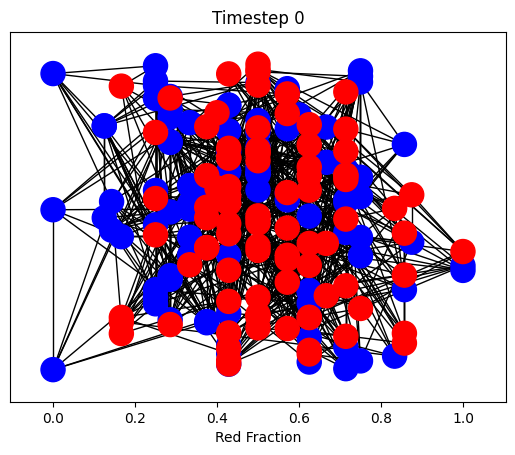

In [85]:
# Helper function to convert internal node id (integer, starting at 0)
    # to our agent IDs (defined above)
def get_agent_id(node_id: int, nodes: NodeView) -> str:
    return nodes[node_id]['id'].replace('"','')

networks = []


for day in range(0, 10):
    friendship = schelling_grid_job.results.network("Friendship", is_directed=False, sim_day=day)[0]
    nodes = friendship.nodes
    
    node_colors = {}
    frac_red_dict = {}
    
    for node in nodes:
        # Extract internal ID of node (node_id) and associated agent (agent_id)
        node_id = node
        agent_id = get_agent_id(node, nodes)
        
        my_color = attributes[agent_id]
        node_colors[node] = my_color
        
        try:
            similarity = mean([int(my_color == attributes[get_agent_id(neighbor, nodes)]) for neighbor in nx.neighbors(friendship, node)])
        except StatisticsError:
            similarity = 1
            
        frac_red_dict[node] = my_color*similarity + (1 - my_color)*(1-similarity)
        
    nx.set_node_attributes(friendship, node_colors, name="my_color")
    nx.set_node_attributes(friendship, frac_red_dict, name="frac_red")
    networks.append(friendship)
    
friendship_final = networks[-1]
blue = [frac for ID, frac in nx.get_node_attributes(friendship_final, 'frac_red').items() if (int(ID) % 1000000000) <  num_blue ]
red = [frac for ID, frac in nx.get_node_attributes(friendship_final, 'frac_red').items() if (int(ID) % 1000000000) >= num_blue ]

print(f'At the end of the simulation:')
print(f'    Average frac_red for blue agents: {round(mean(blue), 3)};')
print(f'    Average frac_red for red agents:  {round(mean(red),  3)}.')
print()

animation = animate.network_visualization(networks)
HTML(animation.to_jshtml())

# Schelling Model on a Random Network

Now, let's adapt the model to the abstract network space. First, we will replace the grid with a randomly generated network. To keep the comparison similar, we specify that each agent should still have 8 possible neighbors. However, unlike in a grid, those neighbor spots need not be connected to each other according to any pattern. 

Second, we can adapt agent behavior to the new setting. When an agent is unhappy --- i.e., when their fraction of similar neighbors is below their desired threshold --- agents in a more abstract space may be more free to change their situation than they would be in a physical environment. So, rather than have agents "move" to an entirely new location, we can instead let agents that are unhappy disconnect an edge to a neighbor who does not share their color and re-connect that edge to a random agent in the network who has at least one of their possible neighbor spots open.

Let's take a look at our outputs under these new conditions:

In [91]:
# Define FRED job configuration

schelling_random_config = ModelConfig(synth_pop=SynthPop("US_2010.v5", ["Loving_County_TX"]),
    start_date = "2023-01-01",
    end_date = "2023-01-10")


# Configure FRED job

results_dir = "/home/epx/cl-results"

schelling_random_job = Job(
    "model/schelling_random_network.fred",
    config=[schelling_random_config],
    key="ng_schelling_random_job",
    results_dir=results_dir,
    size="hot",
    # Select FRED version compatible with selected model
    fred_version="11.0.1"
)

In [92]:
num_blue = 90
num_red = 90
extra = 20

attributes = {
    str(1000000000 + offset): int(offset >= num_blue) for offset in range(num_blue+num_red)
}

lines = ['ID,my_color\n'] + \
        [f'{agent_id},{color}\n' for agent_id, color in attributes.items()] + \
        [f'{1000000000 + offset},{-1}\n' for offset in range(num_red+num_blue,num_red+num_blue+extra)]


with NamedTemporaryFile("w") as temp:
    
    # Write the temporary file
    temp.writelines(lines)
    
    temp.seek(0) # return to beginning of tempfile
    
    shutil.move(temp.name, '_agents.txt') # rename the temporary file to a name that FRED will recognize
    
    exec_job_with_timer(schelling_random_job)
    
    shutil.move('_agents.txt', temp.name) # restore the name of the temporary file to close properly

NOT STARTED at 0.0007467269897460938
NOT STARTED at 3.002960205078125
NOT STARTED at 6.004497528076172
NOT STARTED at 9.007915258407593
NOT STARTED at 12.009562253952026
NOT STARTED at 15.011028051376343
NOT STARTED at 18.014487266540527
NOT STARTED at 21.018012285232544
NOT STARTED at 24.02145028114319
NOT STARTED at 27.023029088974
DONE


In [88]:
# Helper function to convert internal node id (integer, starting at 0)
    # to our agent IDs (defined above)
def get_agent_id(node_id: int, nodes: NodeView) -> str:
    return nodes[node_id]['id'].replace('"','')

networks = []


for day in range(0, 10):
    friendship = schelling_random_job.results.network("Friendship", is_directed=False, sim_day=day)[0]
    nodes = friendship.nodes
    
    node_colors = {}
    frac_red_dict = {}
    
    for node in nodes:
        # Extract internal ID of node (node_id) and associated agent (agent_id)
        node_id = node
        agent_id = get_agent_id(node, nodes)
        
        my_color = attributes[agent_id]
        node_colors[node] = my_color
        
        try:
            similarity = mean([int(my_color == attributes[get_agent_id(neighbor, nodes)]) for neighbor in nx.neighbors(friendship, node)])
        except StatisticsError:
            similarity = 1
            
        frac_red_dict[node] = my_color*similarity + (1 - my_color)*(1-similarity)
        
    nx.set_node_attributes(friendship, node_colors, name="my_color")
    nx.set_node_attributes(friendship, frac_red_dict, name="frac_red")
    networks.append(friendship)
    
friendship_final = networks[-1]
blue = [frac for ID, frac in nx.get_node_attributes(friendship_final, 'frac_red').items() if (int(ID) % 1000000000) <  num_blue ]
red = [frac for ID, frac in nx.get_node_attributes(friendship_final, 'frac_red').items() if (int(ID) % 1000000000) >= num_blue ]

print(f'At the end of the simulation:')
print(f'    Average frac_red for blue agents: {round(mean(blue), 3)};')
print(f'    Average frac_red for red agents:  {round(mean(red),  3)}.')
print()

animation = animate.network_visualization(networks)
HTML(animation.to_jshtml())

KeyError: '0'

The "segregation" that we observe under these new conditions is noticeably less extreme than in the standard model on a grid! (For example, in the original model the average fraction of similar neighbors among all agents at the end of the simulation is more than 5/6, whereas in the new model, it is closer to 4/6).

Why is this the case? That is a great question, and I don't completely know the answer! But, let's test a few hypotheses about features of the grid model that are missing from the random network model that we just formulated and see how they affect the outcomes.  

## Alternative 1: Rewire All Links if Unhappy

One big change that we made, which we discussed above, is the decision to have agents re-connect their edges one at a time when they are unhappy. In the grid model, when an unhappy agent moves to an empty grid location, they (generally speaking) will completely change their set of neighbors all at once. So, for our first change to the random network model, we can have unhappy agents delete all their edges and randomly re-connect them:

In [93]:
# Define FRED job configuration

schelling_random_config = ModelConfig(synth_pop=SynthPop("US_2010.v5", ["Loving_County_TX"]),
    start_date = "2023-01-01",
    end_date = "2023-01-10")


# Configure FRED job

results_dir = "/home/epx/cl-results"

schelling_random_job_2 = Job(
    "model/schelling_random_network_2.fred",
    config=[schelling_random_config],
    key="ng_schelling_random_job_2",
    results_dir=results_dir,
    size="hot",
    # Select FRED version compatible with selected model
    fred_version="11.0.1"
)

In [ ]:
num_blue = 90
num_red = 90
extra = 20

attributes = {
    str(1000000000 + offset): int(offset >= num_blue) for offset in range(num_blue+num_red)
}

lines = ['ID,my_color\n'] + \
        [f'{agent_id},{color}\n' for agent_id, color in attributes.items()] + \
        [f'{1000000000 + offset},{-1}\n' for offset in range(num_red+num_blue,num_red+num_blue+extra)]

with NamedTemporaryFile("w") as temp:
    
    # Write the temporary file
    temp.writelines(lines)
    
    temp.seek(0) # return to beginning of tempfile
    
    shutil.move(temp.name, '_agents.txt') # rename the temporary file to a name that FRED will recognize
    
    exec_job_with_timer(schelling_random_job_2)
    
    shutil.move('_agents.txt', temp.name) # restore the name of the temporary file to close properly

NOT STARTED at 0.000850677490234375
NOT STARTED at 3.004990577697754
NOT STARTED at 6.008519649505615
NOT STARTED at 9.012019157409668
NOT STARTED at 12.015779495239258
NOT STARTED at 15.019231796264648
RUNNING at 18.030800104141235
RUNNING at 21.035587072372437
RUNNING at 24.040337800979614
RUNNING at 27.04538607597351
RUNNING at 30.050020694732666
RUNNING at 33.0542266368866
RUNNING at 36.05808782577515
RUNNING at 39.06280469894409
RUNNING at 42.06645631790161
RUNNING at 45.070287466049194
RUNNING at 48.076438665390015
RUNNING at 51.08512043952942
RUNNING at 54.09009552001953
RUNNING at 57.09485936164856
RUNNING at 60.09979820251465
RUNNING at 63.10449194908142
RUNNING at 66.10943508148193
RUNNING at 69.11480164527893
RUNNING at 72.1195900440216
RUNNING at 75.12196040153503
RUNNING at 78.12651062011719
RUNNING at 81.13128614425659
RUNNING at 84.13473224639893
RUNNING at 87.14103865623474
RUNNING at 90.14601612091064
RUNNING at 93.15101528167725
RUNNING at 96.15575647354126
RUNNING at

At the end of the simulation:
    Average frac_red for blue agents: 0.128;
    Average frac_red for red agents:  0.872.



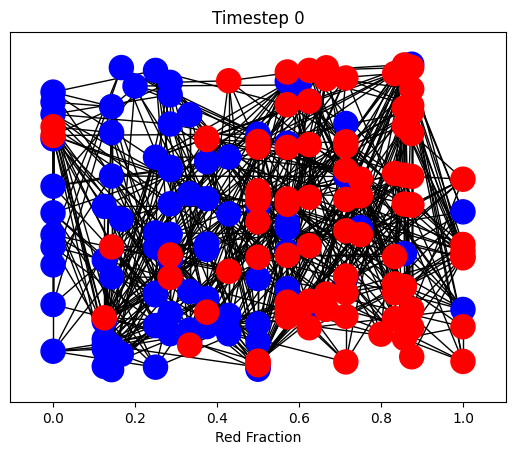

In [39]:
networks = []

for day in range(1, 11):
    friendship = schelling_grid_job.results.network("Friendship", is_directed=False, sim_day=day)[0]
    frac_red_dict = {}
    for node in friendship.nodes:
        my_color = attributes[node]
        try:
            similarity = mean([int(my_color == attributes[neighbor]) for neighbor in nx.neighbors(friendship, node)])
        except StatisticsError:
            similarity = 1
        frac_red_dict[node] = my_color*similarity + (1 - my_color)*(1-similarity)
    nx.set_node_attributes(friendship, attributes, name="my_color")
    nx.set_node_attributes(friendship, frac_red_dict, name="frac_red")
    networks.append(friendship)
    
friendship_final = networks[-1]
blue = [frac for ID, frac in nx.get_node_attributes(friendship_final, 'frac_red').items() if (int(ID) % 1000000000) <  num_blue ]
red = [frac for ID, frac in nx.get_node_attributes(friendship_final, 'frac_red').items() if (int(ID) % 1000000000) >= num_blue ]

print(f'At the end of the simulation:')
print(f'    Average frac_red for blue agents: {round(mean(blue), 3)};')
print(f'    Average frac_red for red agents:  {round(mean(red),  3)}.')
print()

animation = animate.network_visualization(networks)
HTML(animation.to_jshtml())

This appears to have a noticeable effect, but still does not get us all the way to the extreme behavior we observe with the original model. Let's try another change.

## Alternative 2: Rewire All Links within a Neighborhood

Another key feature of the grid that we highlighted previously is the structure that it imposes on neighborhoods. That is, when an agent moves to a new household location in the grid, they necessarily share neighbors with their new neighbors (e.g., their new neighbor to the north is the western neighbor of their neighbor to the northwest). We can incorporate a similar notion in the random network by having unhappy agents preferentially attach to clusters of new neighbors when they re-connect their edges. 

To be precise, when an agent is unhappy in this model, they delete all of their edges, then find a new "central" agent with an open neighbor spot. Then, to re-connect the rest of their deleted edges, they first look to connect with neighbors of the "central" agent. If they cannot re-connect all of their edges with neighbors of the "central" agent, then they look among neighbors and neighbors' neighbors (the "two-hop" neighborhood) of the central agent, and so on. Once they find a radius *r* such that the *r*-hop neighborhood of the central agent contains enough agents with empty neighbor spots, the agent re-connects their edges to agents in that neighborhood. Those agents are selected with probability proportional to their number of hops from the "central" agent.

In [ ]:
# Define FRED job configuration

schelling_random_config = ModelConfig(synth_pop=SynthPop("US_2010.v5", ["Loving_County_TX"]),
    start_date = "2023-01-01",
    end_date = "2023-01-10")


# Configure FRED job

results_dir = "/home/epx/cl-results"

schelling_random_job_3 = Job(
    "model/schelling_random_network_3.fred",
    config=[schelling_random_config],
    key="ng_schelling_random_job_3",
    results_dir=results_dir,
    size="hot",
    # Select FRED version compatible with selected model
    fred_version="11.0.1"
)

In [ ]:
num_blue = 90
num_red = 90
extra = 20

attributes = {
    str(1000000000 + offset): int(offset >= num_blue) for offset in range(num_blue+num_red)
}

lines = ['ID,my_color\n'] + \
        [f'{agent_id},{color}\n' for agent_id, color in attributes.items()] + \
        [f'{1000000000 + offset},{-1}\n' for offset in range(num_red+num_blue,num_red+num_blue+extra)]

with NamedTemporaryFile("w") as temp:
    
    # Write the temporary file
    temp.writelines(lines)
    
    temp.seek(0) # return to beginning of tempfile
    
    shutil.move(temp.name, '_agents.txt') # rename the temporary file to a name that FRED will recognize
    
    exec_job_with_timer(schelling_random_job_3)
    
    shutil.move('_agents.txt', temp.name) # restore the name of the temporary file to close properly

At the end of the simulation:
    Average frac_red for blue agents: 0.128;
    Average frac_red for red agents:  0.872.



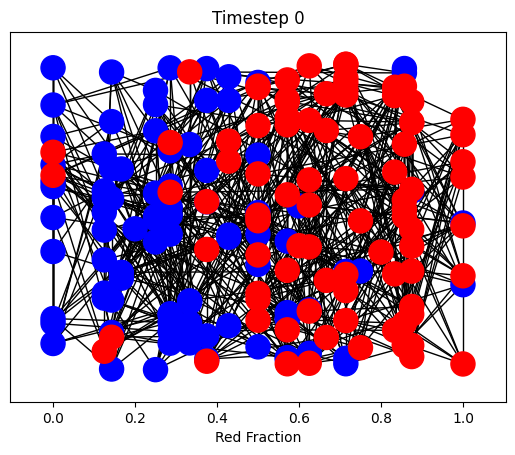

In [42]:
networks = []

for day in range(1, 11):
    friendship = schelling_grid_job.results.network("Friendship", is_directed=False, sim_day=day)[0]
    frac_red_dict = {}
    for node in friendship.nodes:
        my_color = attributes[node]
        try:
            similarity = mean([int(my_color == attributes[neighbor]) for neighbor in nx.neighbors(friendship, node)])
        except StatisticsError:
            similarity = 1
        frac_red_dict[node] = my_color*similarity + (1 - my_color)*(1-similarity)
    nx.set_node_attributes(friendship, attributes, name="my_color")
    nx.set_node_attributes(friendship, frac_red_dict, name="frac_red")
    networks.append(friendship)
    
friendship_final = networks[-1]
blue = [frac for ID, frac in nx.get_node_attributes(friendship_final, 'frac_red').items() if (int(ID) % 1000000000) <  num_blue ]
red = [frac for ID, frac in nx.get_node_attributes(friendship_final, 'frac_red').items() if (int(ID) % 1000000000) >= num_blue ]

print(f'At the end of the simulation:')
print(f'    Average frac_red for blue agents: {round(mean(blue), 3)};')
print(f'    Average frac_red for red agents:  {round(mean(red),  3)}.')
print()

animation = animate.network_visualization(networks)
HTML(animation.to_jshtml())

We can see that the effect of this change is small compared to the first change we made (small enough that the difference may just be due to random chance). So, we are still not able to completely explain which features of the grid network topology are so conducive to facilitating the segregation pattern. But maybe you have a new hypothesis that we haven't tested yet? If so, you can try it out on the Epistemix platform!